## Problem 3

In [1]:
import torch
from torch import Tensor, tensor
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
learning_rate = 5e-4
num_epochs = 2000
reg_coeff = 500
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))
    
    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)
    
    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T

def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)
    
    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
    
    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title)
    plt.show()

In [4]:
class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
        self.data = self.data.to(dtype=torch.float)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]


data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

Define encoder, decoder and functions.

In [15]:
class Encoder(nn.Module):
    def __init__(self, in_dim: int = 2, hidden_dim: int = 128):
        super().__init__()
        self.layer_1 = nn.Linear(in_dim, hidden_dim)
        self.activation_1 = nn.LeakyReLU(negative_slope=0.2)
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.activation_2 = nn.Tanh()
        self.layer_3 = nn.Linear(hidden_dim, 2)    # mu, log_sigma (each of dim 1)
    
    def forward(self, x):
        val = self.activation_1(self.layer_1(x))
        val = self.activation_2(self.layer_2(val))
        val = self.layer_3(val)
        return val[:,:1], val[:,1:]    # mu, log_sigma(std, not var)


class Decoder(nn.Module):
    def __init__(self, in_dim: int = 1, hidden_dim: int = 64):
        super().__init__()
        self.layer_1 = nn.Linear(in_dim, hidden_dim)
        self.activation_1 = nn.LeakyReLU(negative_slope=0.2)
        self.layer_2 = nn.Linear(hidden_dim, hidden_dim)
        self.activation_2 = nn.Tanh()
        self.layer_3 = nn.Linear(hidden_dim, 2)    # x (of dim 2)
    
    def forward(self, x):
        val = self.activation_1(self.layer_1(x))
        val = self.activation_2(self.layer_2(val))
        val = self.layer_3(val)
        return val
        


def reparametrization(mu, log_sigma):
    return torch.randn_like(mu)*log_sigma.exp()+mu


def log_prob(x_hat, x):
    mse_fn = nn.MSELoss().to(device=device)
    return -mse_fn(x_hat, x)

def KL_div(mu, log_sigma):
    kl_div = (mu**2 + torch.exp(2*log_sigma) - 1)/2 - log_sigma
    return kl_div.sum(1).mean()


def loss_fn(x_hat, x, mu, log_sigma):
    log_p = log_prob(x_hat, x)
    kl_div = KL_div(mu, log_sigma)
    return kl_div - 150*log_p



Encoder = Encoder().to(device)
Decoder = Decoder().to(device)
optimizer = torch.optim.Adam(list(Encoder.parameters()) + list(Decoder.parameters()), lr=learning_rate)

Below are training and intermediate results.

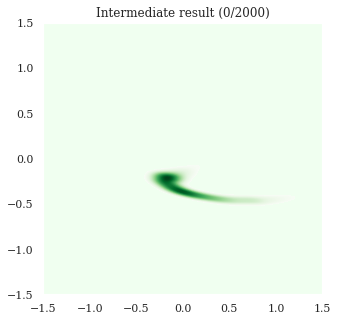

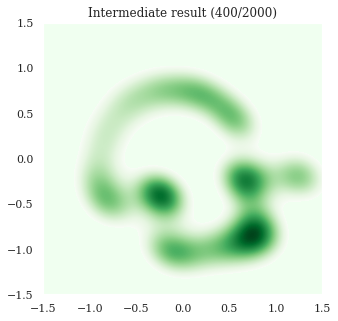

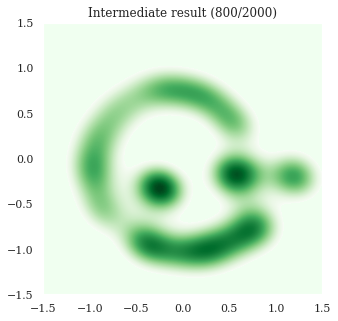

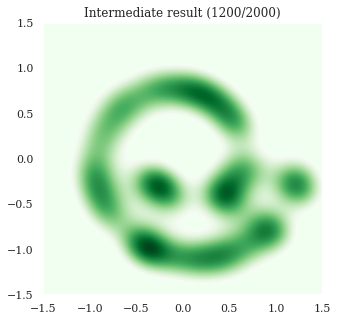

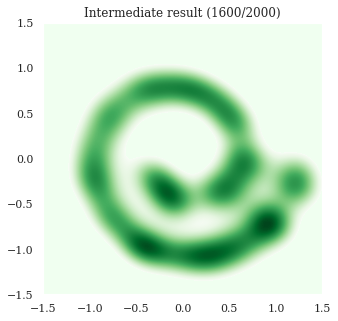

In [16]:
for epoch in range(num_epochs) : 
    for batch_idx, x in enumerate(loader) : 
        x = x.detach().to(device)
        mu, log_sigma = Encoder(x)
        
        z = reparametrization(mu, log_sigma)
        x_hat = Decoder(z)
        
        loss = loss_fn(x_hat, x, mu, log_sigma)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    
    # Visualize the intermediate result
    if epoch % (num_epochs // 5) == 0:
        mu, log_sigma = Encoder(dataset.data.to(device))
        z = reparametrization(mu, log_sigma)
        x_hat = Decoder(z)
        show_data(x_hat.detach().cpu().numpy(), f"Intermediate result ({epoch}/{num_epochs})")

As you can see, roll shape formulates as epoch increases. Final results becomes:

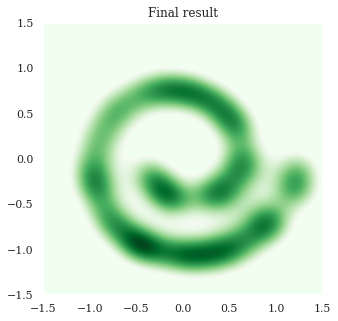

In [17]:
mu, log_sigma = Encoder(dataset.data.to(device))
z = reparametrization(mu, log_sigma)
x_hat = Decoder(z)
show_data(x_hat.detach().cpu().numpy(), f"Final result")